# Environment Setup and Imports

In [1]:
# Install or upgrade the numexpr package
!pip install --upgrade numexpr
!pip install holidays  # Install the holidays package

# Import necessary libraries from SageMaker
import sagemaker  # Main SageMaker module
from sagemaker import get_execution_role  # Function to get the SageMaker execution role
from sagemaker.image_uris import retrieve  # Function to retrieve container image URIs
from sagemaker.estimator import Estimator  # Estimator class for training models

# Import boto3 library for interacting with AWS services
import boto3  # AWS SDK for Python
from botocore.exceptions import ClientError  # Exception class for handling client errors

# Import pandas for data manipulation and analysis
import pandas as pd  # Data manipulation and analysis library

# Import json for working with JSON data
import json  # Library for JSON manipulation

# Import the holidays package for handling holiday-related features
import holidays  # Package for generating lists of holidays

# Import matplotlib.pyplot for creating visualizations
import matplotlib.pyplot as plt  # Plotting library

# Import seaborn for statistical data visualization
import seaborn as sns  # Statistical data visualization library

# Import LabelEncoder from scikit-learn for encoding labels
from sklearn.preprocessing import LabelEncoder  # Encoder for categorical features


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 44.2 MB/s eta 0:00:00
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Data Exploration

In [2]:
# Load the OnlineRetail.csv data into a pandas DataFrame
df_onlineretail = pd.read_csv('OnlineRetail.csv')

In [3]:
# Display the first few rows of the df_onlineretail DataFrame
print(df_onlineretail.head())# Display the first few rows of the df_onlineretail DataFrame

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2009 7:45   6.95      13085.0  United Kingdom  
1  12/1/2009 7:45   6.75      13085.0  United Kingdom  
2  12/1/2009 7:45   6.75      13085.0  United Kingdom  
3  12/1/2009 7:45   2.10      13085.0  United Kingdom  
4  12/1/2009 7:45   1.25      13085.0  United Kingdom  


In [4]:
# Display the number of rows and columns in the df_onlineretail DataFrame
print(df_onlineretail.shape)

(1067371, 8)


In [5]:
# Drop the specified columns from df_onlineretail
columns_to_drop = ['Invoice', 'StockCode', 'Description', 'Customer ID']
df_onlineretail.drop(columns=columns_to_drop, axis=1, inplace=True)

In [6]:
# Display the number of rows and columns in the df_onlineretail DataFrame after dropping columns
print(df_onlineretail.shape)

(1067371, 4)


In [7]:
# Display a concise summary of the df_onlineretail DataFrame
print(df_onlineretail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Quantity     1067371 non-null  int64  
 1   InvoiceDate  1067371 non-null  object 
 2   Price        1067371 non-null  float64
 3   Country      1067371 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 32.6+ MB
None


In [8]:
# Convert the 'InvoiceDate' column to datetime format
df_onlineretail['InvoiceDate'] = pd.to_datetime(df_onlineretail['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [9]:
# Display a concise summary of the df_onlineretail DataFrame to verify the datatime format
print(df_onlineretail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Quantity     1067371 non-null  int64         
 1   InvoiceDate  1067371 non-null  datetime64[ns]
 2   Price        1067371 non-null  float64       
 3   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 32.6+ MB
None


In [10]:
# Calculate the number of missing values in each column
missing_values = df_onlineretail.isnull().sum()

# Print the number of missing values for each column
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Quantity       0
InvoiceDate    0
Price          0
Country        0
dtype: int64


In [11]:
# Filter out rows with negative prices or quantities
negative_prices = df_onlineretail[df_onlineretail['Price'] < 0]
negative_quantities = df_onlineretail[df_onlineretail['Quantity'] < 0]

# Print rows with negative prices
if not negative_prices.empty:
    print("Rows with negative Prices:")
    print(negative_prices)
else:
    print("There are no negative Prices.")

# Print rows with negative quantities
if not negative_quantities.empty:
    print("Rows with negative Quantities:")
    print(negative_quantities)
else:
    print("There are no negative quantities.")

Rows with negative Prices:
        Quantity         InvoiceDate     Price         Country
179403         1 2010-04-29 13:36:00 -53594.36  United Kingdom
276274         1 2010-07-19 11:24:00 -44031.79  United Kingdom
403472         1 2010-10-20 12:04:00 -38925.87  United Kingdom
825444         1 2011-08-12 14:51:00 -11062.06  United Kingdom
825445         1 2011-08-12 14:52:00 -11062.06  United Kingdom
Rows with negative Quantities:
         Quantity         InvoiceDate   Price         Country
178           -12 2009-12-01 10:33:00    2.95       Australia
179            -6 2009-12-01 10:33:00    1.65       Australia
180            -4 2009-12-01 10:33:00    4.25       Australia
181            -6 2009-12-01 10:33:00    2.10       Australia
182           -12 2009-12-01 10:33:00    2.95       Australia
...           ...                 ...     ...             ...
1065910       -11 2011-12-09 09:57:00    0.83  United Kingdom
1067002        -1 2011-12-09 10:28:00  224.69  United Kingdom
106717

In [12]:
# Keep only rows with non-negative prices and quantities
df_onlineretail = df_onlineretail[(df_onlineretail['Price'] >= 0) & (df_onlineretail['Quantity'] >= 0)]

# Print the number of rows removed due to negative prices or quantities
print("Number of rows removed due to negative prices or quantities:", len(negative_prices) + len(negative_quantities))

Number of rows removed due to negative prices or quantities: 22955


# Data Preparation

In [13]:
# Calculate the total sales for each country and date
df_onlineretail['Sales'] = df_onlineretail['Quantity'] * df_onlineretail['Price']
daily_sales_country = df_onlineretail.groupby(['Country', df_onlineretail['InvoiceDate'].dt.floor('D')])['Sales'].sum().reset_index()

# Display the daily sales data grouped by country and date
print(daily_sales_country)

          Country InvoiceDate   Sales
0       Australia  2009-12-01  196.10
1       Australia  2009-12-18   75.00
2       Australia  2010-02-14  662.25
3       Australia  2010-02-21  202.56
4       Australia  2010-02-22  164.85
...           ...         ...     ...
2888  Unspecified  2011-08-22  531.03
2889  Unspecified  2011-09-02  286.85
2890  Unspecified  2011-11-16  333.20
2891  Unspecified  2011-11-24  632.55
2892  West Indies  2010-08-23  536.41

[2893 rows x 3 columns]


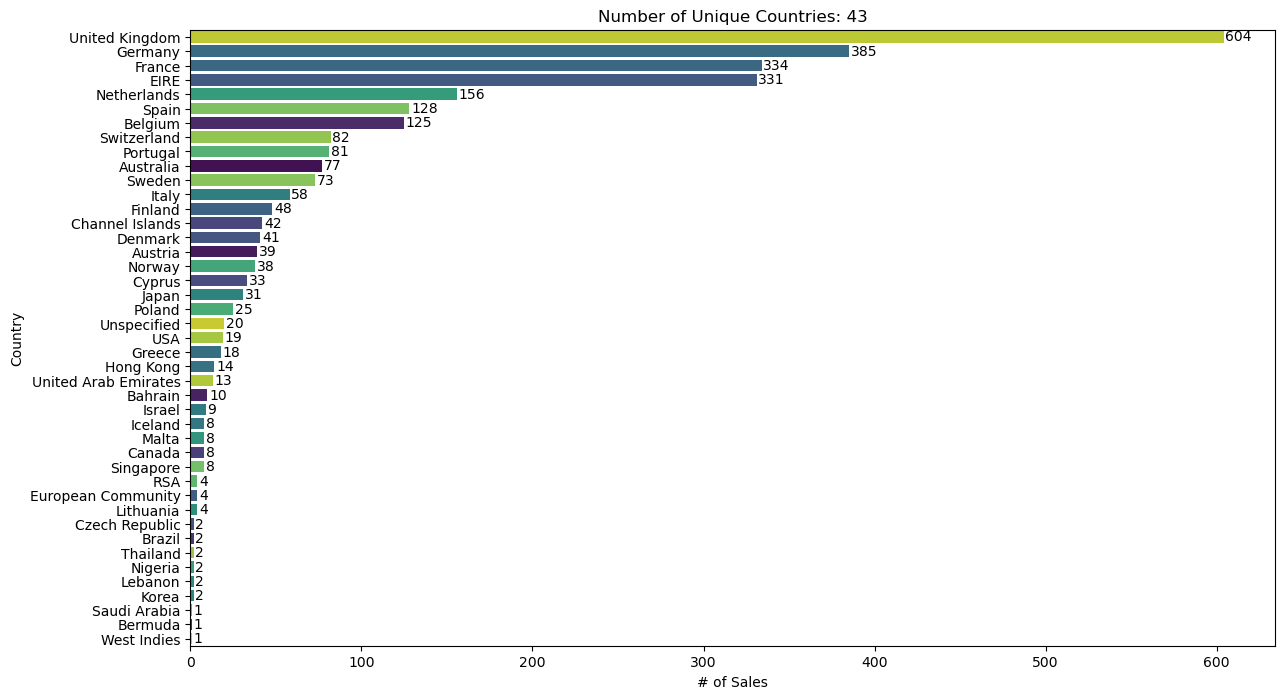

In [14]:
# Count the number of sales by country in the dataset
country_count = daily_sales_country['Country'].nunique()

# Create a horizontal bar plot to visualize the number of sales by country
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=daily_sales_country, y='Country', hue='Country', palette='viridis', order=daily_sales_country['Country'].value_counts().index, legend=False)
plt.ylabel('Country')
plt.xlabel('# of Sales')
plt.title(f'Number of Unique Countries: {country_count}')

# Add count numbers next to the bars
for p in ax.patches:
    width = int(p.get_width())  # Convert width to integer
    plt.text(width + 1, p.get_y() + p.get_height() / 2., f'{width}', ha='left', va='center')

plt.show()

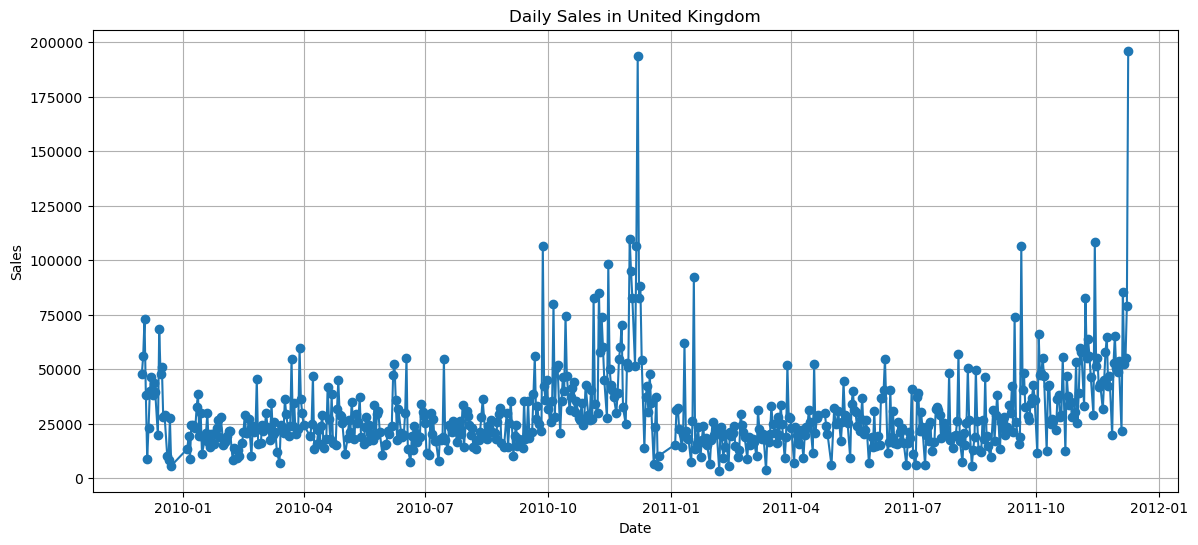

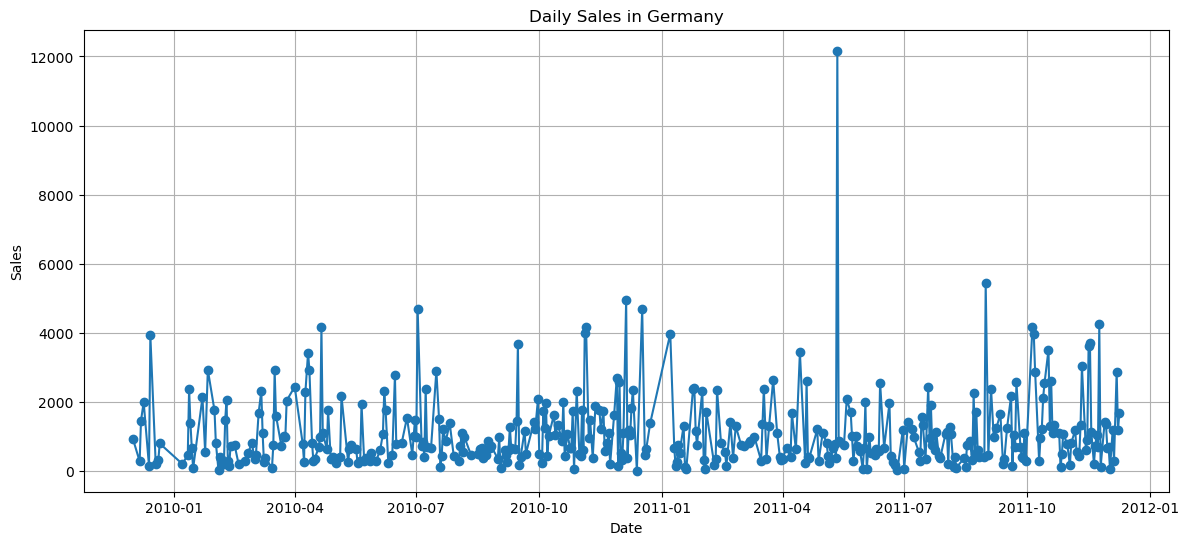

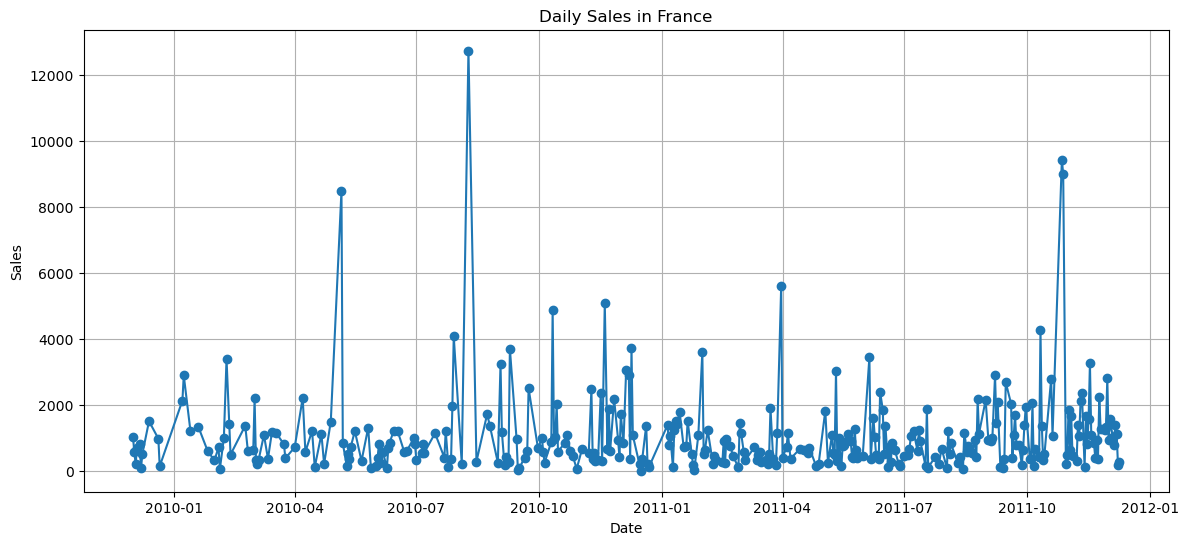

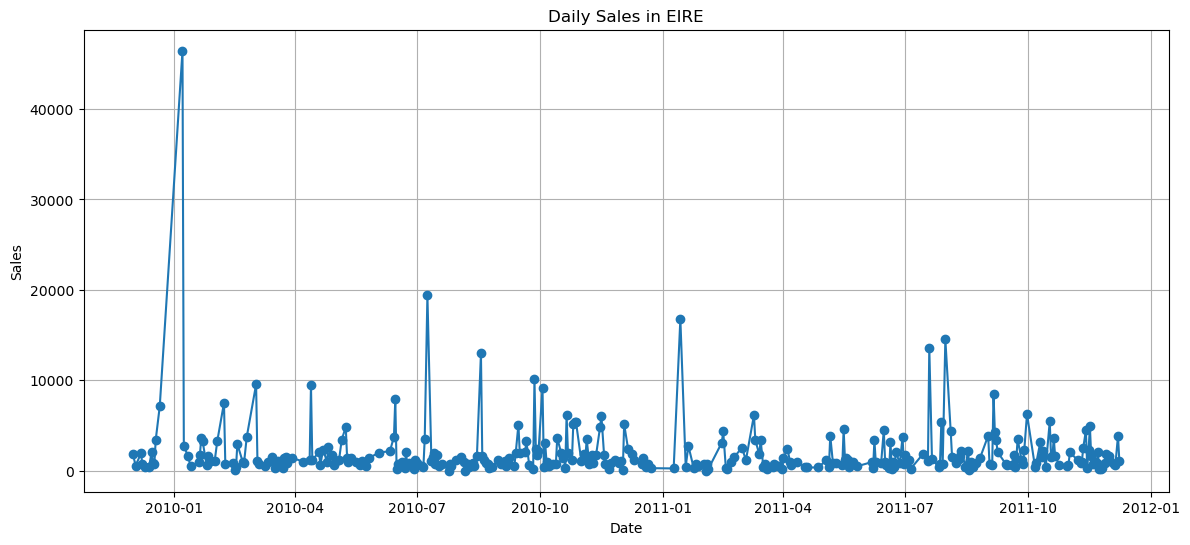

In [15]:
# Filter the DataFrame to include only the specified countries
countries = ['United Kingdom', 'Germany', 'France', 'EIRE']
selected_countries_sales = daily_sales_country[daily_sales_country['Country'].isin(countries)]

# Create separate line plots for each country
for country in countries:
    country_data = selected_countries_sales[selected_countries_sales['Country'] == country]
    plt.figure(figsize=(14, 6))
    plt.plot(country_data['InvoiceDate'], country_data['Sales'], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Daily Sales in {country}')
    plt.grid(True)  # Add a grid for better readability
    plt.show()

# Data Preparation for DeepAR Model Training

In [16]:
def find_countries_not_in_library(df):
    # Get the unique country names from the DataFrame
    countries = df['Country'].unique()
    
    # Initialize a list to store unsupported countries
    unsupported_countries = []
    
    # Check if each country name has a corresponding country code in the holidays library
    for country in countries:
        try:
            holidays.CountryHoliday(country)
        except NotImplementedError:
            unsupported_countries.append(country)
    
    # Print the unsupported countries
    if unsupported_countries:
        print("Countries not supported by the holidays library:")
        for country in unsupported_countries:
            print(country)
    else:
        print("All countries are supported by the holidays library.")

# Find countries not in the holidays library
find_countries_not_in_library(daily_sales_country)

Countries not supported by the holidays library:
Bermuda
Channel Islands
Czech Republic
EIRE
European Community
Hong Kong
Lebanon
RSA
Saudi Arabia
United Arab Emirates
United Kingdom
Unspecified
West Indies


In [17]:
def update_countries_for_holidays(df):
    country_mapping = {
        'United Kingdom': 'GB',
        'EIRE': 'IE',
        'Channel Islands': 'JEY',
        'United Arab Emirates': 'AE',
        'RSA': 'ZA',
        'Bermuda': 'BM',
        'Hong Kong': 'HK',
        'Saudi Arabia': 'SA',
        'Czech Republic': 'CZ'
    }
    
    # Replace country names with corresponding codes
    df['Country'] = df['Country'].replace(country_mapping)

# Update countries for holidays
update_countries_for_holidays(daily_sales_country)

# Drop unsupported countries
countries_to_drop = ['BM', 'European Community', 'LB', 'Unspecified', 'West Indies', 'Lebanon']
daily_sales_country = daily_sales_country[~daily_sales_country['Country'].isin(countries_to_drop)]

# Check for unsupported countries again
find_countries_not_in_library(daily_sales_country)

All countries are supported by the holidays library.


In [18]:
# Create a label encoder instance and encode the 'Country' column
label_encoder = LabelEncoder()
daily_sales_country['Country_Code'] = label_encoder.fit_transform(daily_sales_country['Country'])

# Create a dictionary to map the encoded numbers to their corresponding countries
country_code_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Print the mapping
print("Country Code Mapping:")
print(country_code_mapping)

Country Code Mapping:
{'AE': 0, 'Australia': 1, 'Austria': 2, 'Bahrain': 3, 'Belgium': 4, 'Brazil': 5, 'CZ': 6, 'Canada': 7, 'Cyprus': 8, 'Denmark': 9, 'Finland': 10, 'France': 11, 'GB': 12, 'Germany': 13, 'Greece': 14, 'HK': 15, 'IE': 16, 'Iceland': 17, 'Israel': 18, 'Italy': 19, 'JEY': 20, 'Japan': 21, 'Korea': 22, 'Lithuania': 23, 'Malta': 24, 'Netherlands': 25, 'Nigeria': 26, 'Norway': 27, 'Poland': 28, 'Portugal': 29, 'SA': 30, 'Singapore': 31, 'Spain': 32, 'Sweden': 33, 'Switzerland': 34, 'Thailand': 35, 'USA': 36, 'ZA': 37}


In [19]:
def convert_to_deepar_json(df, filename, is_test=False):
    grouped = df.groupby('Country_Code')
    time_series = []
    for _, group in grouped:
        country_holidays = holidays.CountryHoliday(group['Country'].iloc[0])
        dynamic_feature = [1 if date in country_holidays else 0 for date in group['InvoiceDate']]
        
        # Create a record for each time series
        record = {
            "start": str(group['InvoiceDate'].min()),
            "target": group['Sales'].tolist(),
            "cat": [int(group['Country_Code'].iloc[0])],
            "dynamic_feat": [dynamic_feature]
        }
        if is_test:
            # For the test set, include only the last 'prediction_length' points
            record["target"] = record["target"][-prediction_length:]
            record["dynamic_feat"] = [dynamic_feature[-prediction_length:]]
        time_series.append(record)
    
    # Write the time series to a JSON Lines file
    with open(filename, 'w') as f:
        for ts in time_series:
            f.write(json.dumps(ts) + '\n')

# Set the prediction length
prediction_length = 7  # Adjust this value as needed

# Split the data into training and test sets
train_df = daily_sales_country.copy()
test_df = daily_sales_country.groupby('Country_Code').apply(lambda x: x.tail(prediction_length)).reset_index(drop=True)

# Ensure that the test set has the last 'prediction_length' points for each time series
test_df = test_df.groupby('Country_Code').filter(lambda x: len(x) == prediction_length)

# Convert the training and test sets to DeepAR JSON format
convert_to_deepar_json(train_df, 'train_data.json')
convert_to_deepar_json(test_df, 'test_data.json', is_test=True)

# SageMaker Session and Environment Setup

In [20]:
# Create a SageMaker session for managing interactions with the SageMaker environment
sagemaker_session = sagemaker.Session()

# Retrieve the execution role for the current SageMaker notebook instance
role = get_execution_role()

# Retrieve the AWS region name from the SageMaker session
region = sagemaker_session.boto_region_name

# Specify the DeepAR container image URI for the specified region
image_uri = retrieve('forecasting-deepar', region)

# Define the default Amazon S3 bucket for the SageMaker session
bucket = sagemaker_session.default_bucket()

# Define the prefix for the S3 key where data will be stored
prefix = 'sagemaker/onlineretail/feature-prediction'

# Define the path to the local training data file
local_train = 'train_data.json'

# Define the path to the local validation data file
local_validation = 'test_data.json'

# Upload the local training data file to the specified S3 bucket and prefix, returning the S3 URI
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)

# Upload the local validation data file to the specified S3 bucket and prefix, returning the S3 URI
test_uri = sagemaker_session.upload_data(local_validation, bucket=bucket, key_prefix=prefix)

# Print the execution role ARN, AWS region name, and S3 URIs for the training and validation data
print("Execution Role ARN:", role)
print("AWS Region:", region)
print("Training Data S3 URI:", train_uri)
print("Validation Data S3 URI:", test_uri)


Execution Role ARN: arn:aws:iam::992382709141:role/LabRole
AWS Region: us-east-1
Training Data S3 URI: s3://sagemaker-us-east-1-992382709141/sagemaker/onlineretail/category-feature-prediction/train_data.json
Validation Data S3 URI: s3://sagemaker-us-east-1-992382709141/sagemaker/onlineretail/category-feature-prediction/test_data.json


# Estimator Configuration for DeepAR Algorithm Training

In [21]:
# Define an Estimator for the DeepAR algorithm in SageMaker
deepar_estimator = Estimator(
    sagemaker_session=sagemaker_session,  # Specify the SageMaker session
    image_uri=image_uri,  # Specify the container image URI for the DeepAR algorithm
    role=role,  # Specify the IAM role ARN used by SageMaker
    instance_count=1,  # Specify the number of instances to use for training
    instance_type='ml.m5.large',  # Specify the instance type for training
    output_path=f's3://{bucket}/{prefix}/output',  # Specify the S3 location for saving the model artifacts and output
    base_job_name='onlineretail-deepar-forecasting'  # Specify the base job name for the training job
)

# Set hyperparameters for the DeepAR algorithm
deepar_estimator.set_hyperparameters(
    time_freq='D',  # Specify the time frequency of the data (e.g., 'D' for daily)
    context_length=30,  # Specify the length of the context used for training (e.g., 30 days)
    prediction_length=7,  # Specify the length of the prediction horizon (forecasting 7 days into the future)
    epochs=20,  # Specify the number of training epochs
    early_stopping_patience=10,  # Specify the number of epochs with no improvement before early stopping
    num_dynamic_feat=1,  # Specify the number of dynamic features
    cardinality='auto'  # Automatically detect the cardinality of categorical features (if any)
)


# Model Training with DeepAR Estimator

In [22]:
# Define data channels for training the DeepAR estimator
# Mapping 'train' and 'test' keys to the S3 URIs of the training and test data
data_channels = {
    'train': train_uri,  # Specify the S3 URI for the training data
    'test': test_uri     # Specify the S3 URI for the test data
}

# Fit the DeepAR estimator using the specified data channels
# This step initiates the training job in SageMaker
deepar_estimator.fit(inputs=data_channels)


INFO:sagemaker:Creating training-job with name: onlineretail-deepar-forecasting-2024-02-25-18-36-01-742


2024-02-25 18:36:01 Starting - Starting the training job...
2024-02-25 18:36:17 Starting - Preparing the instances for training...
2024-02-25 18:36:54 Downloading - Downloading input data...
2024-02-25 18:37:25 Downloading - Downloading the training image..................
2024-02-25 18:40:26 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[02/25/2024 18:40:32 INFO 139897781798720] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience

# Model Deployment to SageMaker Endpoint

In [24]:
# Specify the endpoint name
endpoint_name = 'online-retail-endpoint-feat'

# Specify the endpoint configuration name
endpoint_config_name = 'online-retail-endpoint-feat'

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

In [25]:
# Check if the endpoint configuration already exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')


Endpoint configuration "online-retail-endpoint-feat" does not exist.


In [26]:
# Check if the endpoint already exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" deleted.')
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')
    else:
        raise

Endpoint "online-retail-endpoint-feat" does not exist.


In [27]:
# Deploy the trained model to an endpoint
predictor = deepar_estimator.deploy(
    initial_instance_count=1,  # Specify the initial number of instances for the endpoint
    instance_type='ml.m5.large',  # Specify the instance type for the endpoint
    serializer=sagemaker.serializers.JSONSerializer(),  # Specify the serializer for the input data
    deserializer=sagemaker.deserializers.JSONDeserializer(),  # Specify the deserializer for the output data
    endpoint_name=endpoint_name,  # Specify the name of the endpoint
)

# Print the endpoint name and endpoint configuration name
print(f'Endpoint name: {predictor.endpoint_name}')
print(f'Endpoint configuration name: {endpoint_config_name}')

INFO:sagemaker:Creating model with name: onlineretail-deepar-forecasting-2024-02-25-18-42-16-252
INFO:sagemaker:Creating endpoint-config with name online-retail-endpoint-feat
INFO:sagemaker:Creating endpoint with name online-retail-endpoint-feat


---------!Endpoint name: online-retail-endpoint-feat
Endpoint configuration name: online-retail-endpoint-feat


# Preparing Prediction Input for DeepAR Model

In [28]:
# Display the country code list
print("Country Code List:")
for country, code in country_code_mapping.items():
    print(f"{country}: {code}")

# Prompt for the country code
selected_country_code = int(input("Enter the country code for prediction: "))

# Find the country name corresponding to the selected country code
selected_country_name = [country for country, code in country_code_mapping.items() if code == selected_country_code][0]

# Filter the historical data for the selected country
selected_country_sales = daily_sales_country[daily_sales_country['Country_Code'] == selected_country_code]

# Set the prediction length
prediction_length = 7

# Set the prediction start date
prediction_start_date = pd.Timestamp('2011-12-03')

# Generate the holiday dynamic feature for the entire range
all_dates = pd.date_range(start=selected_country_sales['InvoiceDate'].min(), end=prediction_start_date + pd.Timedelta(days=prediction_length - 1), freq='D')
holiday_calendar = holidays.CountryHoliday(selected_country_name)
all_holiday_feature = [1 if date in holiday_calendar else 0 for date in all_dates]

# Prepare the prediction input with the holiday dynamic feature
prediction_input = {
    "instances": [{
        "start": str(selected_country_sales['InvoiceDate'].min()),
        "target": selected_country_sales['Sales'].tolist() + [0] * prediction_length,
        "cat": [selected_country_code],
        "dynamic_feat": [all_holiday_feature]
    }],
    "configuration": {"num_samples": 100, "output_types": ["mean", "quantiles"], "quantiles": ["0.1", "0.9"]}
}

# Invoke the endpoint for prediction
sagemaker_runtime = boto3.client('sagemaker-runtime')
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(prediction_input)
)

# Parse the prediction response
predictions = json.loads(response['Body'].read().decode())
predicted_means = predictions['predictions'][0]['mean']
predicted_quantiles = predictions['predictions'][0]['quantiles']
predicted_lower_quantile = predicted_quantiles['0.1']
predicted_upper_quantile = predicted_quantiles['0.9']

# Create a DataFrame for the predicted sales
predicted_dates = pd.date_range(start=prediction_start_date, periods=prediction_length, freq='D')
predicted_sales = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Sales': predicted_means,
    'Lower Quantile': predicted_lower_quantile,
    'Upper Quantile': predicted_upper_quantile,
})

# Display the predicted sales
print(predicted_sales)

Country Code List:
AE: 0
Australia: 1
Austria: 2
Bahrain: 3
Belgium: 4
Brazil: 5
CZ: 6
Canada: 7
Cyprus: 8
Denmark: 9
Finland: 10
France: 11
GB: 12
Germany: 13
Greece: 14
HK: 15
IE: 16
Iceland: 17
Israel: 18
Italy: 19
JEY: 20
Japan: 21
Korea: 22
Lithuania: 23
Malta: 24
Netherlands: 25
Nigeria: 26
Norway: 27
Poland: 28
Portugal: 29
SA: 30
Singapore: 31
Spain: 32
Sweden: 33
Switzerland: 34
Thailand: 35
USA: 36
ZA: 37


Enter the country code for prediction:  13


        Date  Predicted Sales  Lower Quantile  Upper Quantile
0 2011-12-03       942.633057      204.430786     1710.921143
1 2011-12-04       858.863770      -68.907288     1571.709351
2 2011-12-05       871.323853       50.266968     1557.672363
3 2011-12-06       779.872131      -32.882141     1526.157715
4 2011-12-07       951.360229        5.061157     1966.887451
5 2011-12-08       694.439514     -155.861694     1700.181885
6 2011-12-09       835.322754      140.271179     1430.185669


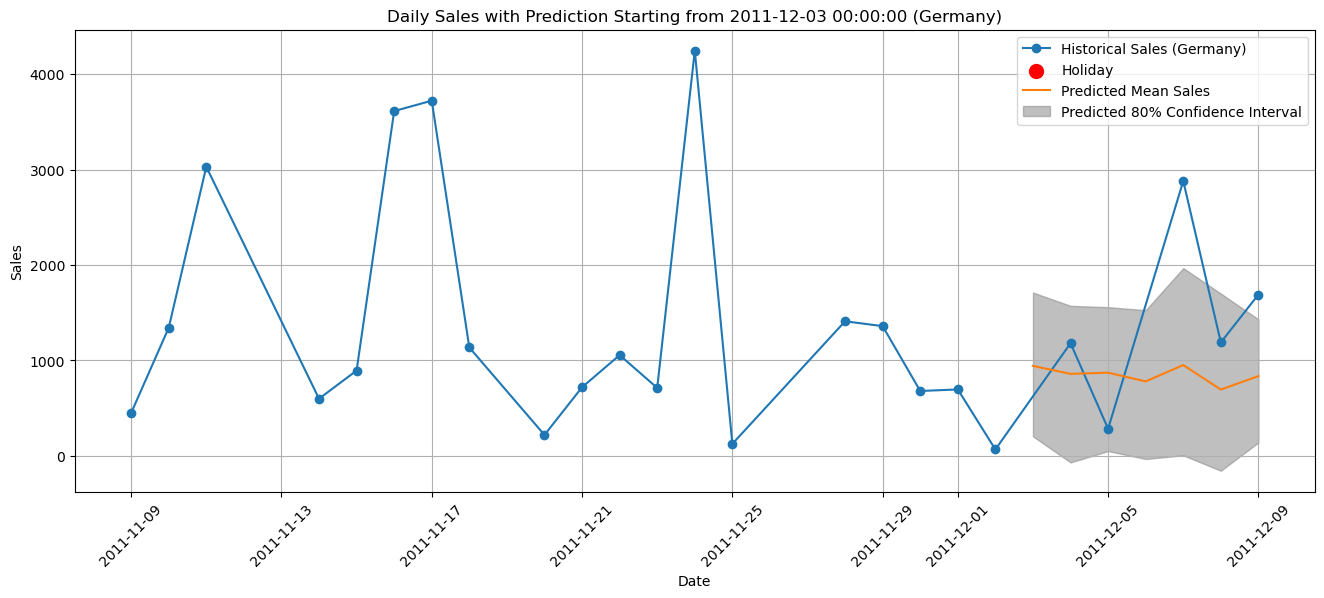

In [30]:
import matplotlib.pyplot as plt

# Filter the historical data to include only the last 30 days for the selected country
last_30_days_sales = selected_country_sales[selected_country_sales['InvoiceDate'] >= (selected_country_sales['InvoiceDate'].max() - pd.Timedelta(days=30))]

# Plot the daily sales for the last 30 days for the selected country
plt.figure(figsize=(16, 6))
plt.plot(last_30_days_sales['InvoiceDate'], last_30_days_sales['Sales'], marker='o', linestyle='-', label=f'Historical Sales ({selected_country_name})')

# Highlight holidays in the historical data
holiday_dates = [date for date in last_30_days_sales['InvoiceDate'] if date in holiday_calendar]
holiday_sales = [last_30_days_sales[last_30_days_sales['InvoiceDate'] == date]['Sales'].values[0] for date in holiday_dates]
plt.scatter(holiday_dates, holiday_sales, color='red', s=100, label='Holiday')

# Plot the predicted mean sales
plt.plot(predicted_dates, predicted_means, label='Predicted Mean Sales')

# Plot the predicted quantiles as a shaded area
plt.fill_between(predicted_dates, predicted_lower_quantile, predicted_upper_quantile, color='gray', alpha=0.5, label='Predicted 80% Confidence Interval')

# Add labels, title, and legend
plt.title(f'Daily Sales with Prediction Starting from {prediction_start_date} ({selected_country_name})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Delete the Endpoint and Endpoint Config

In [49]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")

Are you sure you want to delete the endpoint and endpoint configuration? (yes/no):  no


Deletion cancelled.
